In [ ]:
!pip install scipy==1.9.3 --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.9.3 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.9.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
albumentations 2.0.6 requires scipy>=1.10.0, but you have scipy 1.9.3 which is incompatible.
imbalanced-learn 0.13.0 requires scipy<2,>=1.10.1, but you have scipy 1.9.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.9.3 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.9.3 which is in

In [ ]:
!pip install catboost

In [ ]:
!pip install feature_engine

In [ ]:
!pip install plot-metric --quiet

In [ ]:
import pandas as pd
import numpy as np
import warnings
import joblib
import plotly.express as px
from google.colab import drive
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from plot_metric.functions import BinaryClassification
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 500

from google.colab import auth
import gspread
from google.auth import default
from google.cloud import bigquery
client = bigquery.Client(project='dev-sd-lake')

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
import json
data = {
  "account": "",
  "client_id": "764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com",
  "client_secret": "d-FL95Q19q7MQmFpd7hHD0Ty",
  "quota_project_id": "dev-sd-lake",
  "refresh_token": "1//05nz9IRnR1e2JCgYIARAAGAUSNwF-L9Ir_zi7EkfNFJb02e5XxL3e4Qicf7BN708CjMo66DuPPMhkd09jS6lIra-zubUPFGORcyU",
  "type": "authorized_user",
  "universe_domain": "googleapis.com"
}
json_data = json.dumps(data)
!echo '{json_data}' > '/content/.config/application_default_credentials.json'

In [ ]:
product_listings_query = """
SELECT * FROM pollen.product_listings;
"""
product_listings = client.query_and_wait(product_listings_query).to_dataframe()


products_query = """
SELECT * FROM pollen.products;
"""
products = client.query_and_wait(products_query).to_dataframe()


product_categories_query = """
SELECT * FROM pollen.product_categories;
"""
product_categories = client.query_and_wait(product_categories_query).to_dataframe()


product_subcategories_query = """
SELECT * FROM pollen.product_subcategories;
"""
product_subcategories = client.query_and_wait(product_subcategories_query).to_dataframe()


sellers_query = """
SELECT * FROM pollen.sellers;
"""
sellers = client.query_and_wait(sellers_query).to_dataframe()

In [ ]:
offers_query = """
SELECT * FROM pollen.offers;
"""
offers = client.query_and_wait(offers_query).to_dataframe()

In [ ]:
orders_level_1_query = """
SELECT * FROM pollen.orders_level_1;
"""
orders_level_1 = client.query_and_wait(orders_level_1_query).to_dataframe()

In [ ]:
orders_level_2_query = """
SELECT * FROM pollen.orders_level_2;
"""
orders_level_2 = client.query_and_wait(orders_level_2_query).to_dataframe()

In [ ]:
sellers = sellers[['seller_name', 'persona_seller_type']].drop_duplicates()

In [ ]:
print(product_listings.shape, products.shape, product_categories.shape, product_subcategories.shape, sellers.shape, offers.shape)

(182283, 41) (182291, 9) (30, 3) (223, 4) (109, 2) (18167, 43)


In [ ]:
def get_order_date(df_order_sheet1, df_order_sheet2):
  order_date_to_tracking_no_mapping = df_order_sheet1[['tracking_no', 'order_date']].drop_duplicates()
  df_order_sheet2 = pd.merge(df_order_sheet2, order_date_to_tracking_no_mapping, 'left',  on = ['tracking_no'])
  df_order_sheet2.drop('date_of_order', axis = 1, inplace = True)
  df_order = df_order_sheet2.copy()
  return df_order

orders = get_order_date(orders_level_1, orders_level_2)

In [ ]:
orders = orders.drop_duplicates(subset = ['sku_number', 'expiry_date', 'tracking_no'])
offers = offers.drop_duplicates(subset = ['sku_number', 'expiry_date', 'tracking_no'])
offers = offers.rename(columns = {'total_units' : 'total_units_offered'})
orders = orders.rename(columns = {'total_units' : 'total_units_ordered', 'total_offer_price_usd' : 'total_order_price_usd'})

offers = pd.merge(offers, orders[['sku_number', 'expiry_date', 'tracking_no', 'total_units_ordered', 'recovery_rate_percentage',
                                  'total_order_price_usd', 'domestic_export']], 'left', on = ['sku_number', 'expiry_date', 'tracking_no'])

In [ ]:
product_subcategories = product_subcategories.rename(columns = {'id' : 'subcategory_id', 'name' : 'product_subcategory'})
product_categories = product_categories.rename(columns = {'id' : 'category_id', 'name' : 'product_category'})

products = pd.merge(products, product_categories, 'left', on = 'category_id')
products = pd.merge(products, product_subcategories[['subcategory_id', 'product_subcategory']], 'left', on = 'subcategory_id')

In [ ]:
products = products.rename(columns = {'id' : 'product_id'})
products = products.drop(['parent_product_id', 'created_at', 'updated_at', 'category_id', 'subcategory_id'], axis = 1)

product_listings = product_listings.drop(['created_at', 'updated_at', 'pollen_updated_price_per_unit_local',
                       'barcode', 'barcode_key', 'manufactured_date', 'batch_number', 'image_links', 'usd_conversion', 'scoring'], axis = 1)
product_listings = pd.merge(product_listings, products, 'left', on = 'product_id')

In [ ]:
product_listings.head(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_number_of_items,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory
0,2d61c777-e0d5-4744-b9eb-dd24f74ee061,44642cbd-8752-4f55-a368-669f22e9e8f8,SE1712631761502,SE1712631761502G4311200,L'Oreal Indonesia,2025-01-01,Carton,64.20,60.0,3852.0,IDR,24900.0,5991.5,31.0,g,0.01,254.0,156.0,219.0,MM,2.24,Bekasi,Indonesia,-,-,NaN,P2,1.53,0.37,CORE,2024-05-28,G4311200,GRN 2 STEP PW MASK B5 GOJI EB,GARNIER,SKIN CARE,SKIN CARE,MASKS & EXFOLIATORS
1,41508680-7c85-47aa-a54c-2bcbbddb56e9,6ca31813-8cac-4459-a53e-d68b62bf337d,SE1712631761502,SE1712631761502G4218000,L'Oreal Indonesia,2025-01-28,Carton,58.43,60.0,3506.0,IDR,23400.0,6552.7,19.7,g,0.01,185.0,150.0,197.0,MM,1.42,Bekasi,Indonesia,-,-,NaN,P2,1.44,0.40,CORE,2024-05-28,G4218000,GRN 5 MIN AMP MASK WATERMELON EB,GARNIER,SKIN CARE,SKIN CARE,MASKS & EXFOLIATORS


In [ ]:
product_listings.inventory_class.value_counts()

,count
inventory_class,
NON_CORE,115580
CORE,66703


In [ ]:
df_inv = product_listings[product_listings.inventory_class == 'CORE']
non_core_inv = product_listings[product_listings.inventory_class == 'NON_CORE']
df_inv = df_inv.reset_index(drop = True)
non_core_inv = non_core_inv.reset_index(drop = True)

In [ ]:
cols_list_underscore_cleaning = ['sku_product_name', 'brand', 'product_category', 'product_subcategory', 'warehouse_country',
            'country_of_origin', 'pack_label_language', 'product_restricted_countries', 'shelf_life_bucket']

inv_cols_list_to_change_dtypes = ['qty_of_cartons', 'units_per_cartons', 'retail_price_per_case_(local)', 'retail_price_per_case_(usd)', 'asking_price_per_case_(local)',
                              'asking_price_per_case_(usd)', 'total_retail_price_(local)', 'total_retail_price_(usd)', 'total_asking_price_(local)',
                              'total_asking_price_(usd)', 'pack_size_(number)', 'total_cbm', 'cbm_per_case', 'package_dimensions_per_package_type_(length)',
                              'package_dimensions_per_case_(width)', 'package_dimensions_per_case_(height)', 'net_weight_\nper_unit(kg)', 'net_weight_per_case_(kg)',
                              'gross_weight_per_case_(kg)', 'total_net_weight_(kg)', 'total_gross_weight_(kg)', 'cases_per_pallet', 'number_of_pallets', 'discount',
                              'shelf_remaining_days']

record_attributes = ['sku_number', 'sku_name', 'brand', 'product_category', 'product_subcategory', 'retail_price_per_unit_local', 'currency']

n_days_before_date = pd.to_datetime(date.today() - timedelta(days = 14))

THRESHOLD = 0.65

In [ ]:
def dropping_null_brand_cat_subcats(df_inv):
  df_inv = df_inv[~df_inv.brand.isnull()]
  df_inv = df_inv[~df_inv.product_category.isnull()]
  df_inv = df_inv[~df_inv.product_subcategory.isnull()]
  return df_inv

def cols_to_lower_rem_space(df, cols_list):
  for col in ['sku_name', 'product_name', 'brand', 'brand_', 'product_description', 'product_category', 'product_sub_category', 'product_subcategory',\
              'warehouse_location', 'buyer', 'seller', 'package_type', 'deal_type', 'origin_', 'destination', 'region_of_export', \
              'domestic_export', 'order_type', 'country', 'currency', 'country_of_origin', 'pack_label_language', 'dangerous_goods\n(y/n)', 'shelf_life_bucket',
              'relavant_(r)/ir-relavant(ir)', 'product_restricted_countries', 'store_name', 'quarter', 'temp_reference', 'tracking_no', 'offer_type', 'fiscal_month',
              'proposed_buyer_product_preferences', 'product_shelf_life_months', 'priority', 'seller', 'lms_seller_id', 'persona', 'core_vs._\nnon_core', 'sku_product_name',
              'warehouse_country', 'warehouse_address', 'measurement_units', 'listing_currency', 'manufacturing_country', 'lbh_measurement_units', 'package_type', 'seller_name',
              'pack_size_unit', 'package_labeled_language', 'inventory_class', 'description', 'unit_dimensions']:
              if col in cols_list:
                df[col] = df[col].str.lower().str.replace(' ', '_')
  return df

def remove_starting_and_trailing_underscores(x):
  if x != '':
    if x[0] == '_':
      for i in range(len(x)):
        if x[i] != '_':
          start = i
          break
      x = x[start:]
    if x[-1] == '_':
      for i in reversed(range(len(x))):
        if x[i] != '_':
          end = i
          break
      x = x[:end+1]
  return x

def cleaning_underscores_inv_data(df_inv, col_list):
  for col in col_list:
    print(col)
    df_inv[col] = df_inv[col].apply(remove_starting_and_trailing_underscores)
  return df_inv

def drop_dups_and_clean(df_inv):
  print('Dropping above duplicates ...')
  df_inv = df_inv.drop_duplicates()
  return df_inv

# Non core

In [ ]:
df_inv = dropping_null_brand_cat_subcats(df_inv)
df_inv = cols_to_lower_rem_space(df_inv, df_inv.columns)
df_inv = drop_dups_and_clean(df_inv)

non_core_inv = cols_to_lower_rem_space(non_core_inv, non_core_inv.columns)

Dropping above duplicates ...


In [ ]:
non_core_inv.head(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_number_of_items,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory
0,b61c2bb9-f203-4447-bd21-34c8b2d8a03a,c741e020-cae7-4258-b71f-3bc338b38412,SE1712631761542,SE171263176154204R3I1MKJPD97H7OBZ60UTU1Z,acommerce_singapore,2023-05-31,pieces,NaN,NaN,6.0,sgd,19.9,1.99,NaN,None,0.0,10.0,10.0,10.0,cm,0.50,sg-acom01,None,None,None,NaN,p1,15.116504,1.511650,non_core,2023-01-25,04R3I1MKJPD97H7OBZ60UTU1Z,l'oreal_paris_color_riche_satin_105_nude_in_paris,l'oreal_paris,makeup,makeup,lip_makeup
1,329218a0-49c7-4e36-bfe7-e10d17de8dfc,0cec2d8c-024a-4929-87fa-358f264016b7,SE1712631761542,SE171263176154211YAP8LR1W3OQSFJGWCLTD1DQ,acommerce_singapore,2023-05-31,pieces,NaN,NaN,160.0,sgd,2.0,0.20,NaN,None,0.0,8.0,5.0,0.2,cm,0.15,sg-acom02,None,None,None,NaN,p1,1.519247,0.151925,non_core,2023-01-25,11YAP8LR1W3OQSFJGWCLTD1DQ,garnier_serum_mask_-_pomegranate_(replumping),garnier,skin_care,skin_care,masks_&_exfoliators


In [ ]:
non_core_inv = non_core_inv.rename(columns = {'total_number_of_items' : 'total_units'})
non_core_inv['updated_on'] = pd.to_datetime(non_core_inv['updated_on'])
non_core_inv['expiry_date'] = pd.to_datetime(non_core_inv['expiry_date'])

In [ ]:
print(non_core_inv.shape)
non_core_inv = non_core_inv.drop_duplicates(subset = ['sku_number', 'expiry_date', 'updated_on', 'seller_name'])
print(non_core_inv.shape)

(115580, 37)
(64433, 37)


In [ ]:
offers = offers.rename(columns = {'seller' : 'seller_name'})
offers['date_of_offer'] = pd.to_datetime(offers['date_of_offer'])
offers['seller_name'] = offers['seller_name'].str.lower()
offers['total_units_ordered'] = offers['total_units_ordered'].str.replace(',', '')
offers['total_units_ordered'] = offers['total_units_ordered'].astype(float)

In [ ]:
def merge_non_core_inv_and_offer(non_core_inv, df_offer):
  temp = pd.merge(non_core_inv, df_offer[['sku_number', 'seller_name', 'date_of_offer', 'actual', 'tracking_no', 'buyer', 'total_units_ordered',
                                          'recovery_rate_percentage', 'offer_price_per_unit_usd', 'total_order_price_usd', 'domestic_export']], 'left', on = ['sku_number', 'seller_name'])
  # temp['updated_on'] = pd.to_datetime(temp['updated_on'])
  temp['offer_day_diff_updated_inv'] = (temp['date_of_offer'] - temp['updated_on']).dt.days
  # avoiding future entry from same sku and seller to get filtered out hence nulling it as will remain in the dataframe
  temp['offer_day_diff_updated_inv'] = np.where(temp.offer_day_diff_updated_inv < 0, np.nan, temp['offer_day_diff_updated_inv'])
  temp = temp[(temp.offer_day_diff_updated_inv >= 0) | (temp.offer_day_diff_updated_inv.isnull())]
  df_non_core_inv_min_offer_day_diff_updated_inv = temp.groupby(['sku_number', 'seller_name', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                        .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  temp = pd.merge(temp, df_non_core_inv_min_offer_day_diff_updated_inv, 'left', on = ['sku_number', 'seller_name', 'date_of_offer'])
  temp = temp[(temp.offer_day_diff_updated_inv == temp.min_offer_day_diff_updated_inv) | (temp.offer_day_diff_updated_inv.isnull())]
  temp.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return temp

In [ ]:
non_core_inv = merge_non_core_inv_and_offer(non_core_inv, offers)
non_core_inv['total_units_ordered'] = non_core_inv['total_units_ordered'].fillna(0)
non_core_inv['sell_thru_rate'] = non_core_inv['total_units_ordered'] / non_core_inv['total_units']
non_core_inv['sell_thru_rate'] = np.where(non_core_inv['sell_thru_rate'] > 1, 1, non_core_inv['sell_thru_rate'])
non_core_inv['shelf_life_remaining_days'] = (non_core_inv['expiry_date'] - non_core_inv['updated_on']).dt.days

In [ ]:
def remove_percent_sign(x):
  if pd.isna(x):
    return x
  else:
    return x[:-1]
non_core_inv['recovery_rate_percentage'] = non_core_inv['recovery_rate_percentage'].apply(remove_percent_sign)
non_core_inv['recovery_rate_percentage'] = np.where(non_core_inv['recovery_rate_percentage'] == '', np.nan, non_core_inv['recovery_rate_percentage'])
non_core_inv['recovery_rate_percentage'] = non_core_inv['recovery_rate_percentage'].astype(float)
non_core_inv['recovery_rate_percentage'] = np.where(non_core_inv['recovery_rate_percentage'].isnull(), 0 , non_core_inv['recovery_rate_percentage'])

In [ ]:
non_core_inv.head(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_units,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory,date_of_offer,actual,tracking_no,buyer,total_units_ordered,recovery_rate_percentage,offer_price_per_unit_usd,total_order_price_usd,domestic_export,offer_day_diff_updated_inv,sell_thru_rate,shelf_life_remaining_days
0,b61c2bb9-f203-4447-bd21-34c8b2d8a03a,c741e020-cae7-4258-b71f-3bc338b38412,SE1712631761542,SE171263176154204R3I1MKJPD97H7OBZ60UTU1Z,acommerce_singapore,2023-05-31,pieces,NaN,NaN,6.0,sgd,19.9,1.99,NaN,None,0.0,10.0,10.0,10.0,cm,0.50,sg-acom01,None,None,None,NaN,p1,15.116504,1.511650,non_core,2023-01-25,04R3I1MKJPD97H7OBZ60UTU1Z,l'oreal_paris_color_riche_satin_105_nude_in_paris,l'oreal_paris,makeup,makeup,lip_makeup,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,126.0
1,329218a0-49c7-4e36-bfe7-e10d17de8dfc,0cec2d8c-024a-4929-87fa-358f264016b7,SE1712631761542,SE171263176154211YAP8LR1W3OQSFJGWCLTD1DQ,acommerce_singapore,2023-05-31,pieces,NaN,NaN,160.0,sgd,2.0,0.20,NaN,None,0.0,8.0,5.0,0.2,cm,0.15,sg-acom02,None,None,None,NaN,p1,1.519247,0.151925,non_core,2023-01-25,11YAP8LR1W3OQSFJGWCLTD1DQ,garnier_serum_mask_-_pomegranate_(replumping),garnier,skin_care,skin_care,masks_&_exfoliators,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,126.0


# Core

In [ ]:
offers = offers.rename(columns = {'seller_name' : 'seller_short'})

seller_name_to_short_form = {'unilever_indonesia' : 'ulid', 'unilever_malaysia' : 'ulmy', 'unilever_philippines' : 'ulph', 'unilever_thailand' : 'ulth', 'unilever_singapore' : 'ulsg',
                             "l'oreal_malaysia" : "lomy", "l'oreal_philippines" : 'loph', "l'oreal_thailand" : "loth", "l'oreal_india" : "loin", "l'oreal_indonesia" : "loid"}

df_inv['updated_on'] = pd.to_datetime(df_inv['updated_on'])

def apply_seller_short(x):
  if x in seller_name_to_short_form.keys():
    return seller_name_to_short_form[x]
  else:
    return x

df_inv['seller_short'] = df_inv['seller_name'].apply(apply_seller_short)

offers = offers[offers['expiry_date'] != '-']
offers['expiry_date'] = pd.to_datetime(offers['expiry_date'], format = "%d-%b-%Y")
df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'])

In [ ]:
def merge_inv_and_offer(df_inv, df_offer):
  df_inv = pd.merge(df_inv, df_offer[['sku_number', 'expiry_date', 'seller_short', 'date_of_offer', 'actual', 'tracking_no', 'buyer', 'total_units_ordered',
                                      'recovery_rate_percentage', 'offer_price_per_unit_usd', 'total_order_price_usd', 'domestic_export']], 'left', on = ['sku_number', 'expiry_date', 'seller_short'])
  df_inv['offer_day_diff_updated_inv'] = (df_inv['date_of_offer'] - df_inv['updated_on']).dt.days
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv >= 0) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_min_offer_day_diff_updated_inv = df_inv.groupby(['sku_number', 'expiry_date', 'seller_short', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                      .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  df_inv = pd.merge(df_inv, df_min_offer_day_diff_updated_inv, 'left', on = ['sku_number', 'expiry_date', 'seller_short', 'date_of_offer'])
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv == df_inv.min_offer_day_diff_updated_inv) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_inv.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return df_inv

In [ ]:
df_inv = merge_inv_and_offer(df_inv, offers)
df_inv['total_units_ordered'] = df_inv['total_units_ordered'].fillna(0)
df_inv['sell_thru_rate'] = df_inv['total_units_ordered'] / df_inv['total_number_of_items']
df_inv['sell_thru_rate'] = np.where(df_inv['sell_thru_rate'] > 1, 1, df_inv['sell_thru_rate'])
df_inv['shelf_life_remaining_days'] = (df_inv['expiry_date'] - df_inv['updated_on']).dt.days

In [ ]:
def remove_percent_sign(x):
  if pd.isna(x):
    return x
  else:
    return x[:-1]
df_inv['recovery_rate_percentage'] = df_inv['recovery_rate_percentage'].apply(remove_percent_sign)
df_inv['recovery_rate_percentage'] = np.where(df_inv['recovery_rate_percentage'] == '', np.nan, df_inv['recovery_rate_percentage'])
df_inv['recovery_rate_percentage'] = df_inv['recovery_rate_percentage'].astype(float)
df_inv['recovery_rate_percentage'] = np.where(df_inv['recovery_rate_percentage'].isnull(), 0 , df_inv['recovery_rate_percentage'])

In [ ]:
# removing some rows which are common on ['sku_number', 'expiry_date', 'seller_short', 'updated_on']. Why ?
# when matching inventory to offers, the inventory which is offered multiple times gets repeated. Which is fine and we wish to consider that
# but there are still some combos in inv which were not offered, buyer is null for them, still they are repeated with almost the same complete row. We need to remove such rows

temp = df_inv[df_inv.duplicated(subset = ['sku_number', 'expiry_date', 'seller_short', 'updated_on'])]
to_remove_ids = temp[temp.buyer.isnull()].id
print(len(to_remove_ids))

5114


In [ ]:
df_inv = df_inv[~df_inv.id.isin(to_remove_ids)]
df_inv.shape

(51519, 50)

In [ ]:
df_inv = df_inv.rename(columns = {'total_number_of_items' : 'total_units'})
df_inv['updated_on'] = pd.to_datetime(df_inv['updated_on'])
df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'])
df_inv = df_inv[df_inv.sku_number != '']
df_inv['seller_name'] = df_inv['seller_short']
df_inv = df_inv.drop('seller_short', axis = 1)

In [ ]:
total_inv = pd.concat([df_inv, non_core_inv], ignore_index=True)

In [ ]:
def get_target(df):
  df['sellability'] = np.where(df.date_of_offer.isnull(), 0, 1)
  print(df.sellability.value_counts())
  return df

total_inv = get_target(total_inv)

sellability
0    101760
1     14264
Name: count, dtype: int64


In [ ]:
total_inv.sample(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_units,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory,date_of_offer,actual,tracking_no,buyer,total_units_ordered,recovery_rate_percentage,offer_price_per_unit_usd,total_order_price_usd,domestic_export,offer_day_diff_updated_inv,sell_thru_rate,shelf_life_remaining_days,sellability
25528,6d6aea9c-252e-42c4-9fc6-e093b76259d9,3fc5f8e8-4d29-44a3-bd48-e9cb01ddebea,SE1712631761498,SE171263176149867041259,ulph,2022-10-05,carton,3.0,16.0,48.0,usd,2.71,1.01,100.0,g,0.01,375.0,149.0,177.0,mm,5.57,"laguna,_philippines",philippines,None,None,NaN,p2,2.710000,1.010000,core,2021-12-10,67041259,dove_bar_ccnt_mlk_trple_pack_(3)_16x100g,dove,skin_care,skin_care,body_cleansing,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,299.0,0
96665,91d49daf-c3be-4b54-bfbd-35b337a1a5ce,b51eab38-9959-47ba-91a3-9026d2405dd0,None,None,excess2sell,NaT,pieces,NaN,NaN,3.0,inr,6299.00,607.00,NaN,s,NaN,NaN,NaN,NaN,-,NaN,india,india,-,-,NaN,p3,72.499405,6.986369,non_core,2025-03-12,E2S16804,ishin_women_maroon_kurta_set_with_duppattamaroon,home,home_improvement_and_tools,home_improvement_and_tools,women's_tops,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0


In [ ]:
def get_order_price_per_unit(df):
  if df['total_units_ordered'] == 0:
    return 0
  else:
    return df['total_order_price_usd'] / df['total_units_ordered']

total_inv['total_order_price_usd'] = total_inv['total_order_price_usd'].str.replace(',', '')
total_inv['total_order_price_usd'] = total_inv['total_order_price_usd'].astype(float)
total_inv['order_price_per_unit_usd'] = total_inv.apply(get_order_price_per_unit, axis = 1)

total_inv['offer_price_per_unit_usd'] = total_inv['offer_price_per_unit_usd'].str.replace(',', '')
total_inv['offer_price_per_unit_usd'] = total_inv['offer_price_per_unit_usd'].astype(float)

In [ ]:
total_inv = total_inv[~total_inv['retail_price_per_unit_usd'].isin([0, np.nan])]

In [ ]:
total_inv.sample()

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_units,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory,date_of_offer,actual,tracking_no,buyer,total_units_ordered,recovery_rate_percentage,offer_price_per_unit_usd,total_order_price_usd,domestic_export,offer_day_diff_updated_inv,sell_thru_rate,shelf_life_remaining_days,sellability,order_price_per_unit_usd
23029,8394882a-c22c-47ce-9d16-3ce6d6dc11c3,e9fd38e7-c7f9-4e2e-a90a-f473f7d3c3db,SE1712631761498,SE171263176149867496266,ulph,2021-08-08,carton,10.0,24.0,240.0,usd,2.05,0.37,170.0,ml,0.01,263.0,238.0,191.0,mm,4.91,"laguna,_philippines",philippines,None,None,NaN,None,2.05,0.37,core,2022-01-21,67496266,tresemme_hc_total_salon_repair_24x170ml,tresemme,hair_care,hair_care,conditioner,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-166.0,0,0.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans


# Step 2: Columns to exclude from clustering
cols_to_ignore = [
    'id', 'product_id', 'seller_id', 'record_id', 'expiry_date',
    'package_labeled_language', 'product_restriction', 'updated_on',
    'date_of_offer', 'actual', 'tracking_no', 'buyer']

# Step 3: Create clustering dataset
df_cluster = total_inv.drop(columns=cols_to_ignore)

# Step 4: Encode categorical columns (excluding domestic_export)
categorical_cols = df_cluster.select_dtypes(include='object').columns.tolist()
if 'domestic_export' in categorical_cols:
    categorical_cols.remove('domestic_export')

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cluster[col] = df_cluster[col].astype(str)
    df_cluster[col] = le.fit_transform(df_cluster[col])
    label_encoders[col] = le

# Step 5: Fill missing values for clustering
df_cluster.fillna(0, inplace=True)

# Step 6: Scale features (excluding domestic_export)
X_features = df_cluster.drop(columns=['domestic_export'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Step 7: Run KMeans with fixed K = 10
k = 100
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
total_inv['cluster'] = kmeans.fit_predict(X_scaled)
print(f"\n KMeans clustering completed with K = {k}")
print('score - ', silhouette_score(X_scaled, total_inv['cluster']))

# Step 8: Impute missing domestic_export values by cluster mode
def impute_domestic_export(row):
    if pd.notna(row['domestic_export']):
        return row['domestic_export']
    cluster_rows = total_inv[(total_inv['cluster'] == row['cluster']) & (total_inv['domestic_export'].notna())]
    if not cluster_rows.empty:
        return cluster_rows['domestic_export'].mode()[0]
    return 'Domestic'  # fallback default

total_inv['domestic_export'] = total_inv.apply(impute_domestic_export, axis=1)

# Optional: Flag imputed rows
total_inv['domestic_export_imputed'] = total_inv['domestic_export'].isna() & total_inv['domestic_export'].notna()

# Step 9: Clean up
total_inv.drop(columns=['cluster'], inplace=True)

# Optional: Count imputed rows
imputed_count = total_inv['domestic_export_imputed'].sum()
print(f"\n Imputed {imputed_count} missing 'domestic_export' values using KMeans clustering.")

total_inv['domestic_export'] = total_inv['domestic_export'].str.lower()


 KMeans clustering completed with K = 100
score -  0.3036837505028182

 Imputed 0 missing 'domestic_export' values using KMeans clustering.


In [ ]:
total_inv['domestic_export'].value_counts()

,count
domestic_export,
domestic,105266
export,4744


In [ ]:
inv_without_offer = total_inv[total_inv.sellability == 0]
inv_with_offer = total_inv[total_inv.sellability == 1]

In [ ]:
def get_dummy_prices_for_inv_without_offers(df):
    return list(np.random.uniform(low = df['asking_price_per_unit_usd'], high = df['retail_price_per_unit_usd'], size = (2,))) + [df['asking_price_per_unit_usd']]

inv_without_offer['test_price_per_unit_usd'] = inv_without_offer.apply(get_dummy_prices_for_inv_without_offers, axis = 1)

inv_without_offer = inv_without_offer.explode('test_price_per_unit_usd')
inv_without_offer['sellability'] = np.where((inv_without_offer['test_price_per_unit_usd'] == inv_without_offer['asking_price_per_unit_usd']), 1, inv_without_offer['sellability'])

In [ ]:
def get_dummy_prices_for_inv_with_offers(df):
  if df['total_units_ordered'] != 0:
    return list(np.random.uniform(low = df['order_price_per_unit_usd'], high = df['asking_price_per_unit_usd'], size = (2,))) + [df['order_price_per_unit_usd']] + [df['asking_price_per_unit_usd']] +\
           list(np.random.uniform(low = df['asking_price_per_unit_usd'], high = df['retail_price_per_unit_usd'], size = (2,)))
  else:
    return list(np.random.uniform(low = 0, high = df['offer_price_per_unit_usd'], size = (2,))) + [df['offer_price_per_unit_usd']] + [df['asking_price_per_unit_usd']] +\
           list(np.random.uniform(low = df['asking_price_per_unit_usd'], high = df['retail_price_per_unit_usd'], size = (2,)))

inv_with_offer = inv_with_offer[~inv_with_offer['offer_price_per_unit_usd'].isin([0, np.nan])]
inv_with_offer['test_price_per_unit_usd'] = inv_with_offer.apply(get_dummy_prices_for_inv_with_offers, axis = 1)

inv_with_offer = inv_with_offer.explode('test_price_per_unit_usd')

# for inv_with_offer where units have been ordered (converted offers), not just order_price_per_unit_usd is sellable but prices above that also sellable
# but where units have NOT been ordered (non-converted offers), not just the offer_price_per_unit_usd is not sellable but also the prices less than offer_price_per_unit_usd are also not sellable

inv_with_offer['sellability'] = np.where((inv_with_offer['total_units_ordered'] == 0) & (inv_with_offer['test_price_per_unit_usd'] <= inv_with_offer['offer_price_per_unit_usd']),
                                         0, inv_with_offer['sellability'])

inv_with_offer['sellability'] = np.where( ((inv_with_offer['total_units_ordered'] == 0) &
 ((inv_with_offer['test_price_per_unit_usd'] > inv_with_offer['asking_price_per_unit_usd']) & (inv_with_offer['test_price_per_unit_usd'] <= inv_with_offer['retail_price_per_unit_usd'])) ),
                                         0, inv_with_offer['sellability'])

inv_with_offer['sellability'] = np.where( ( (inv_with_offer['total_units_ordered'] != 0) &
 ((inv_with_offer['test_price_per_unit_usd'] > inv_with_offer['asking_price_per_unit_usd']) & (inv_with_offer['test_price_per_unit_usd'] <= inv_with_offer['retail_price_per_unit_usd'])) ),
                                         0, inv_with_offer['sellability'])

In [ ]:
total_inv_after_sampled = pd.concat([inv_without_offer, inv_with_offer], ignore_index=True)
total_inv_after_sampled['order_price_per_unit_usd'] = total_inv_after_sampled['test_price_per_unit_usd']
total_inv_after_sampled = total_inv_after_sampled.drop('test_price_per_unit_usd', axis = 1)

## adding listing type

In [ ]:
def get_listing_type(df):
  if df['shelf_life_remaining_days'] > 365*2:
    return 'fresh'
  elif df['shelf_life_remaining_days'] > 365 and df['recovery_rate_percentage'] > 0 and df['recovery_rate_percentage'] < 10:
    return 'obsolete'
  else:
    return 'excess'

total_inv_after_sampled['listing_condition'] = total_inv_after_sampled.apply(get_listing_type, axis = 1)

number_of_rows_to_randomize = int(total_inv_after_sampled.shape[0]*0.05)

change = total_inv_after_sampled.sample(number_of_rows_to_randomize//2).index
total_inv_after_sampled.loc[change,'listing_condition'] = 'damaged'
change = total_inv_after_sampled.sample(number_of_rows_to_randomize//2).index
total_inv_after_sampled.loc[change,'listing_condition'] = 'made_to_order'

In [ ]:
total_inv_after_sampled['listing_condition'].value_counts()

,count
listing_condition,
excess,333756
fresh,10714
made_to_order,9093
damaged,8858
obsolete,1299


## adding liquidation channel

In [ ]:
total_inv_after_sampled['liquidation_channel'] = [['friends/family', 'distributor', 'retailer', 'liquidator', 'disposal', 'pollen']]*len(total_inv_after_sampled)
total_inv_after_sampled = total_inv_after_sampled = total_inv_after_sampled.explode('liquidation_channel')
total_inv_after_sampled = total_inv_after_sampled.reset_index(drop = True)

sellable_inv_after_sampled = total_inv_after_sampled[total_inv_after_sampled.sellability == 1]
non_sellable_inv_after_sampled = total_inv_after_sampled[total_inv_after_sampled.sellability == 0]

In [ ]:
# price correction with multiplying factors wrt to pollen order price from order data
def correct_order_price(df):
  if df['liquidation_channel'] == 'pollen':
    return df['order_price_per_unit_usd']
  elif df['liquidation_channel'] == 'friends/family':
    return df['order_price_per_unit_usd'] * 2
  elif df['liquidation_channel'] == 'retailer':
    return df['order_price_per_unit_usd'] * 1.6
  elif df['liquidation_channel'] == 'distributor':
    return df['order_price_per_unit_usd'] * 1.2
  elif df['liquidation_channel'] == 'liquidator':
    return df['order_price_per_unit_usd'] * 0.8
  elif df['liquidation_channel'] == 'disposal':
    return df['order_price_per_unit_usd'] * 0.05

sellable_inv_after_sampled['order_price_per_unit_usd'] = sellable_inv_after_sampled.apply(correct_order_price, axis = 1)

In [ ]:
total_inv_after_sampled = pd.concat([sellable_inv_after_sampled, non_sellable_inv_after_sampled], ignore_index=True)

In [ ]:
total_inv_after_sampled = total_inv_after_sampled.rename(columns = {'offer_day_diff_updated_inv' : 'time'})

In [ ]:
total_inv_after_sampled.sample()

In [ ]:
total_inv_after_sampled_copy = total_inv_after_sampled.copy()

In [ ]:
total_inv_after_sampled = total_inv_after_sampled_copy

In [ ]:
train_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'total_units', 'shelf_life_remaining_days',
              'time', 'listing_condition', 'retail_price_per_unit_usd', 'order_price_per_unit_usd']
cat_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'listing_condition']

print(total_inv_after_sampled[train_cols].duplicated().sum())
total_inv_after_sampled = total_inv_after_sampled.drop_duplicates(subset = train_cols)
total_inv_after_sampled = total_inv_after_sampled[~total_inv_after_sampled['product_category'].isnull()]

In [ ]:
total_inv_after_sampled.sellability.value_counts()

In [ ]:
target_col = 'sellability'


# 3. Stratified split
X = total_inv_after_sampled[train_cols]
y = total_inv_after_sampled[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Compute class weights (inverse of class frequencies)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. Prepare CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_cols, weight=[class_weights_dict[label] for label in y_train])
val_pool = Pool(X_val, y_val, cat_features=cat_cols)

In [ ]:
print(X_train.shape, X_val.shape)

(753608, 11) (188403, 11)


In [ ]:
# 6. Model parameters
sales_prob_price_model_params = {
    'loss_function': 'Logloss',
    'learning_rate': 0.3,
    'colsample_bylevel': 0.6,
    'depth': 4,
    'min_data_in_leaf': 20,
    'subsample': 0.6,
    'od_wait': 30,
    'custom_metric': 'AUC:hints=skip_train~false',
    'random_seed': 42
}

sales_prob_price_model = CatBoostClassifier(**sales_prob_price_model_params, iterations = 1000)
sales_prob_price_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
pred_probs = sales_prob_price_model.predict_proba(X_val)

0:	learn: 0.6733691	test: 0.6567759	best: 0.6567759 (0)	total: 1.11s	remaining: 18m 34s
1:	learn: 0.6332621	test: 0.6056882	best: 0.6056882 (1)	total: 1.98s	remaining: 16m 26s
2:	learn: 0.6057958	test: 0.5779843	best: 0.5779843 (2)	total: 3.56s	remaining: 19m 43s
3:	learn: 0.5857284	test: 0.5578838	best: 0.5578838 (3)	total: 5.11s	remaining: 21m 11s
4:	learn: 0.5646262	test: 0.5371664	best: 0.5371664 (4)	total: 7.03s	remaining: 23m 18s
5:	learn: 0.5524014	test: 0.5262351	best: 0.5262351 (5)	total: 8.28s	remaining: 22m 51s
6:	learn: 0.5454245	test: 0.5200499	best: 0.5200499 (6)	total: 9.13s	remaining: 21m 35s
7:	learn: 0.5427972	test: 0.5153169	best: 0.5153169 (7)	total: 9.82s	remaining: 20m 18s
8:	learn: 0.5339541	test: 0.5080594	best: 0.5080594 (8)	total: 10.7s	remaining: 19m 40s
9:	learn: 0.5240180	test: 0.4963756	best: 0.4963756 (9)	total: 11.6s	remaining: 19m 6s
10:	learn: 0.5192674	test: 0.4930846	best: 0.4930846 (10)	total: 12.4s	remaining: 18m 37s
11:	learn: 0.5126125	test: 0.48

In [ ]:
# tune the threshold
def plot_metrics_report(y_val, pred_probs, t):
  bc = BinaryClassification(y_val, pred_probs[:, 1], labels=["Not Sellable", "Sellable"])
  # Figures
  plt.figure(figsize=(15,10))
  plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
  bc.plot_roc_curve(threshold = t)
  plt.subplot2grid((2,6), (0,2), colspan=2)
  bc.plot_precision_recall_curve(threshold = t)
  plt.subplot2grid((2,6), (0,4), colspan=2)
  bc.plot_class_distribution(pal_colors=['r','g','m','k'], threshold = t)
  plt.subplot2grid((2,6), (1,1), colspan=2)
  a = bc.plot_confusion_matrix(threshold = t)

  plt.show()
  bc.print_report(threshold = t)

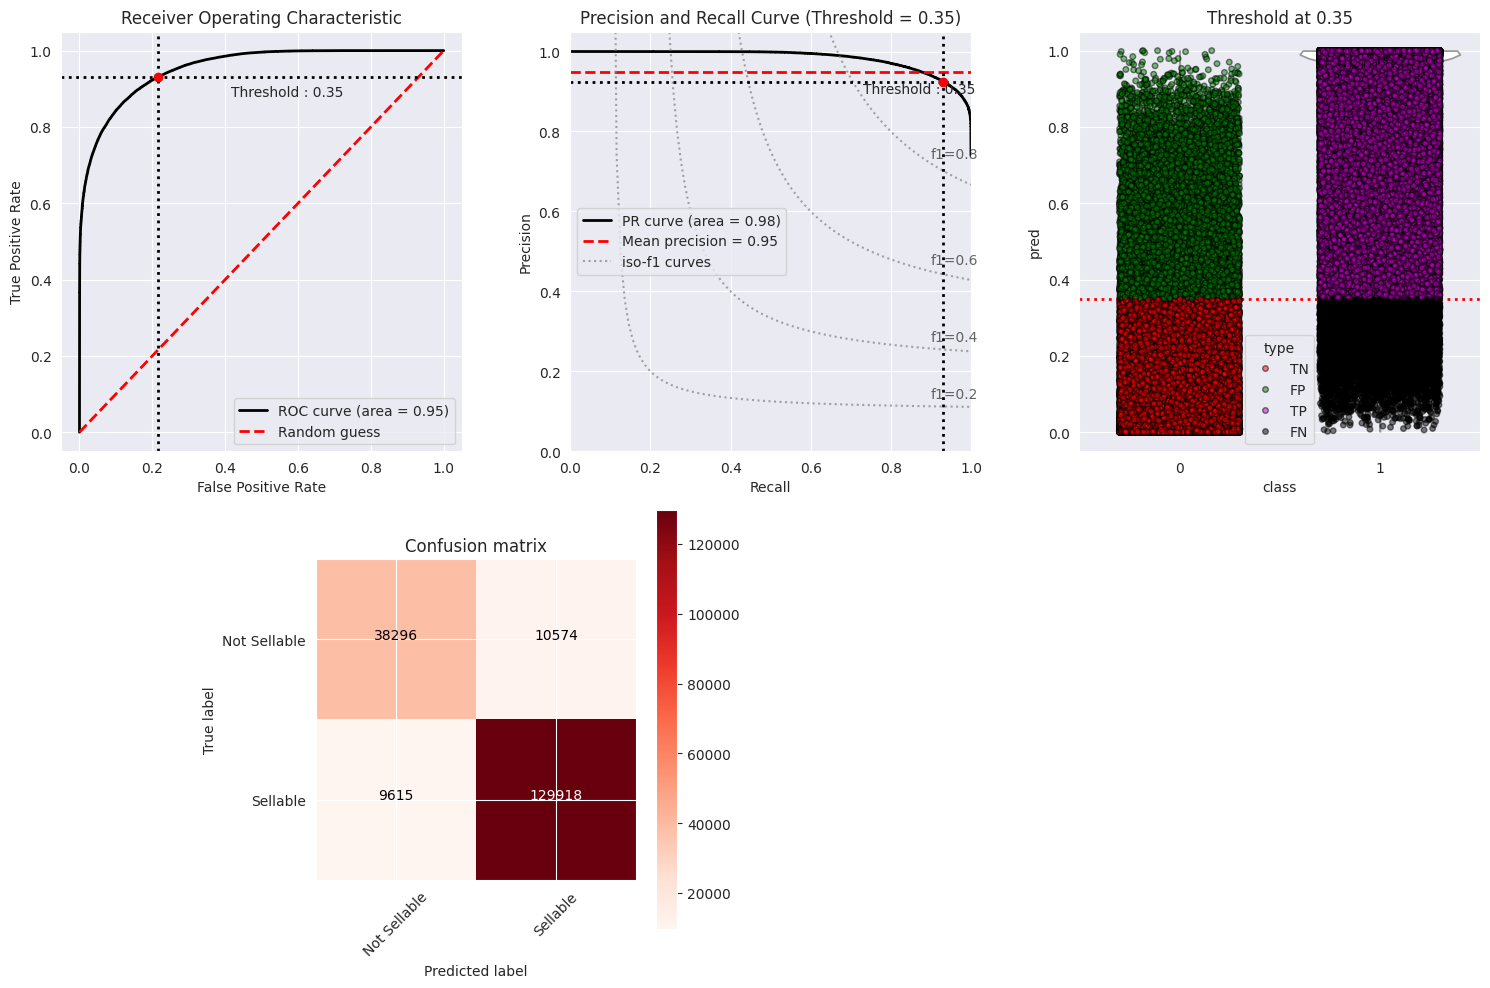

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

Not Sellable       0.80      0.78      0.79     48870
    Sellable       0.92      0.93      0.93    139533

    accuracy                           0.89    188403
   macro avg       0.86      0.86      0.86    188403
weighted avg       0.89      0.89      0.89    188403



In [ ]:
plot_metrics_report(y_val, pred_probs, t = 0.35)

In [ ]:
train_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'total_units', 'shelf_life_remaining_days',
              'time', 'listing_condition', 'retail_price_per_unit_usd', 'order_price_per_unit_usd', 'domestic_export']
cat_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'listing_condition', 'domestic_export']

print(total_inv_after_sampled[train_cols].duplicated().sum())
total_inv_after_sampled = total_inv_after_sampled.drop_duplicates(subset = train_cols)
total_inv_after_sampled = total_inv_after_sampled[~total_inv_after_sampled['product_category'].isnull()]

target_col = 'sellability'


# 3. Stratified split
X = total_inv_after_sampled[train_cols]
y = total_inv_after_sampled[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Compute class weights (inverse of class frequencies)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. Prepare CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_cols, weight=[class_weights_dict[label] for label in y_train])
val_pool = Pool(X_val, y_val, cat_features=cat_cols)


# 6. Model parameters
domestic_export_price_model_params = {
    'loss_function': 'Logloss',
    'learning_rate': 0.3,
    'colsample_bylevel': 0.6,
    'depth': 4,
    'min_data_in_leaf': 20,
    'subsample': 0.6,
    'od_wait': 30,
    'custom_metric': 'AUC:hints=skip_train~false',
    'random_seed': 42
}

domestic_export_price_model = CatBoostClassifier(**domestic_export_price_model_params, iterations = 1000)
domestic_export_price_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
pred_probs = domestic_export_price_model.predict_proba(X_val)

0
0:	learn: 0.6470638	test: 0.6387698	best: 0.6387698 (0)	total: 1.11s	remaining: 18m 27s
1:	learn: 0.6120107	test: 0.5954398	best: 0.5954398 (1)	total: 2.15s	remaining: 17m 53s
2:	learn: 0.5894454	test: 0.5724794	best: 0.5724794 (2)	total: 3.45s	remaining: 19m 6s
3:	learn: 0.5679356	test: 0.5545982	best: 0.5545982 (3)	total: 5.13s	remaining: 21m 16s
4:	learn: 0.5531500	test: 0.5416360	best: 0.5416360 (4)	total: 6.37s	remaining: 21m 8s
5:	learn: 0.5448950	test: 0.5259316	best: 0.5259316 (5)	total: 7.16s	remaining: 19m 46s
6:	learn: 0.5353859	test: 0.5176024	best: 0.5176024 (6)	total: 7.95s	remaining: 18m 47s
7:	learn: 0.5269842	test: 0.5092791	best: 0.5092791 (7)	total: 8.67s	remaining: 17m 54s
8:	learn: 0.5242418	test: 0.5010417	best: 0.5010417 (8)	total: 9.59s	remaining: 17m 35s
9:	learn: 0.5180861	test: 0.4929572	best: 0.4929572 (9)	total: 10.3s	remaining: 17m 4s
10:	learn: 0.5163632	test: 0.4885332	best: 0.4885332 (10)	total: 11.1s	remaining: 16m 34s
11:	learn: 0.5114676	test: 0.48

In [ ]:
plot_metrics_report(y_val, pred_probs, t = 0.35)

In [ ]:
train_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'total_units', 'shelf_life_remaining_days',
              'time', 'listing_condition', 'retail_price_per_unit_usd', 'order_price_per_unit_usd', 'domestic_export']
cat_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'listing_condition', 'domestic_export']

print(total_inv_after_sampled[train_cols].duplicated().sum())
total_inv_after_sampled = total_inv_after_sampled.drop_duplicates(subset = train_cols)
total_inv_after_sampled = total_inv_after_sampled[~total_inv_after_sampled['product_category'].isnull()]

target_col = 'sellability'


# 3. Stratified split
X = total_inv_after_sampled[train_cols]
y = total_inv_after_sampled[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Compute class weights (inverse of class frequencies)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. Prepare CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_cols, weight=[class_weights_dict[label] for label in y_train])
val_pool = Pool(X_val, y_val, cat_features=cat_cols)


# 6. Model parameters
domestic_export_price_model_params = {
    'loss_function': 'Logloss',
    'learning_rate': 0.3,
    'colsample_bylevel': 0.6,
    'depth': 4,
    'min_data_in_leaf': 20,
    'subsample': 0.6,
    'od_wait': 30,
    'custom_metric': 'AUC:hints=skip_train~false',
    'random_seed': 42
}

domestic_export_price_model = CatBoostClassifier(**domestic_export_price_model_params, iterations = 1000)
domestic_export_price_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
pred_probs = domestic_export_price_model.predict_proba(X_val)

In [ ]:
# def dump_files_for_inference_pipeline():
#   print('Dumping files for inference later ...')
#   joblib.dump(sales_prob_price_model, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/sales_prob_price_model.pkl')
#   joblib.dump(domestic_export_price_model, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/domestic_export_price_model.pkl')
#   joblib.dump(X_train, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/X_train.pkl')
#   joblib.dump(X_val, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/X_val.pkl')
#   joblib.dump(y_train, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/y_train.pkl')
#   joblib.dump(y_val, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/y_val.pkl')

In [ ]:
# dump_files_for_inference_pipeline()